TF-IDF matrix shape: (10000, 22)
Album and Genre Combined Similarity Matrix for User 'User_8':
[[1.         0.         0.         0.         0.48884066 0.
  0.         0.         0.6996945  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.70320795
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.69840324 0.
  0.51276457 0.        ]
 [0.         0.         0.         1.         0.51514212 0.
  0.         0.         0.         0.         0.52285808 0.
  0.         0.         0.         0.         0.         0.
  0.         0.48415376]
 [0.48884066 0.         0.         0.51514212 1.         0.
  0.         0.  

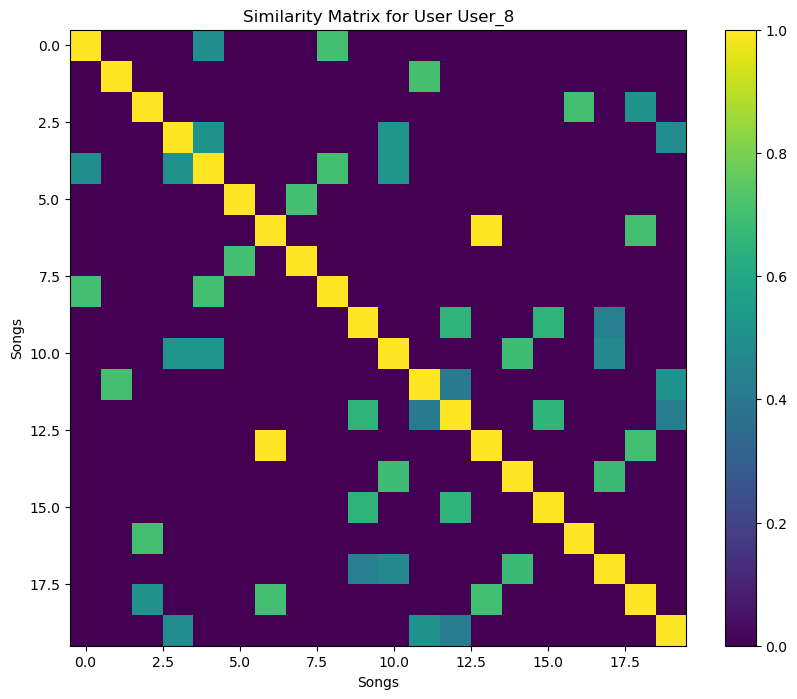

Top 5 Recommendations for User 'User_8':
- Song ID: Song_1
- Song ID: Song_6756
- Song ID: Song_2640
- Song ID: Song_7000
- Song ID: Song_6996


In [3]:
import requests
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load data and models (example placeholders)
user_data = pd.read_csv(r'C:\Users\hp\Desktop\.vscode\merging\dataset 1 - Spotify_data.csv')
spotify_songs = pd.read_csv(r'C:\Users\hp\Desktop\.vscode\merging\DATA - spotify_dataset.csv')
# # Assuming these are placeholders for your pickle files
# lyric_similarity_mapping = pickle.load(open(r'C:\Users\hp\Desktop\.vscode\new\lyric_similarity_mapping.pkl', 'rb'))
# energy_similarity_mapping = pickle.load(open(r'C:\Users\hp\Desktop\.vscode\new\energy_similarity_mapping.pkl', 'rb'))
# mood_similarity_mapping = pickle.load(open(r'C:\Users\hp\Desktop\.vscode\new\mood_similarity_mapping.pkl', 'rb'))

# Rename columns for merging
spotify_songs = spotify_songs.rename(columns={'track_id': 'Song_ID', 'track_popularity': 'Popularity'})
user_data = user_data.rename(columns={'User ID': 'User_ID'})

# Merge user data with song data based on 'User_ID'
merged_df = pd.merge(user_data, spotify_songs, on='User_ID', how='inner')

# Collaborative Filtering Dataset
cf_features = ['User_ID', 'Song_ID', 'Popularity']
cf_filtered = merged_df[cf_features]

# Content-Based Filtering Dataset
cbf_features = ['Song_ID', 'Genre', 'Album']
cbf_filtered = merged_df[cbf_features].copy()

# Fill NaN values in textual features
text_features = ['Genre', 'Album']
for feature in text_features:
    cbf_filtered[feature] = cbf_filtered[feature].fillna('')

# TF-IDF on textual features for Content-Based Filtering
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
cbf_filtered['combined_features'] = cbf_filtered[text_features].apply(lambda x: ' '.join(x), axis=1)
textual_features = tfidf_vectorizer.fit_transform(cbf_filtered['combined_features'])

# Ensure the data is sufficient
if textual_features.shape[0] == 0 or textual_features.shape[1] == 0:
    print("Insufficient data for TF-IDF vectorization.")
else:
    print(f"TF-IDF matrix shape: {textual_features.shape}")

cosine_sim = cosine_similarity(textual_features, textual_features)

# Collaborative Filtering Recommendation Function
user_item_matrix = cf_filtered.pivot_table(index='User_ID', columns='Song_ID', values='Popularity', fill_value=0)
sparse_matrix = csr_matrix(user_item_matrix.values)
user_similarity = cosine_similarity(sparse_matrix, dense_output=False)

def get_cf_recommendations(user_id, top_n=5):
    if user_id not in user_item_matrix.index:
        return []
    
    user_index = user_item_matrix.index.get_loc(user_id)
    similarity_scores = user_similarity[user_index].toarray().ravel()
    similarity_scores[user_index] = 0

    similarity_df = pd.DataFrame({'user': user_item_matrix.index, 'similarity': similarity_scores}).set_index('user')
    target_user_songs = user_item_matrix.loc[user_id]
    unseen_songs = target_user_songs[target_user_songs == 0].index

    song_scores = pd.Series(0, index=unseen_songs)
    for similar_user_id, row in similarity_df[similarity_df['similarity'] > 0].iterrows():
        sim_score = row['similarity']
        similar_user_songs = user_item_matrix.loc[similar_user_id]
        for song_id in unseen_songs:
            song_scores[song_id] += similar_user_songs[song_id] * sim_score

    top_recommendations = song_scores.sort_values(ascending=False).head(top_n).index.tolist()
    return top_recommendations

def recommend_music(user_id, num_recommendations=5):
    try:
        user_index = merged_df.index[merged_df['User_ID'] == user_id].tolist()[0]
        sim_scores = list(enumerate(cosine_sim[user_index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        recommended_indices = [i[0] for i in sim_scores[1:num_recommendations + 1]]

        return merged_df.iloc[recommended_indices]['Song_ID'].tolist()
    except IndexError:
        return []

def get_hybrid_recommendations(user_id, cf_weight=0.5, cbf_weight=0.5, top_n=5):
    cf_recommendations = get_cf_recommendations(user_id, top_n * 2)
    cbf_recommendations = recommend_music(user_id, top_n * 2)

    cf_scores = pd.Series(np.linspace(cf_weight, cf_weight / top_n, num=len(cf_recommendations)), index=cf_recommendations)
    cbf_scores = pd.Series(np.linspace(cbf_weight, cbf_weight / top_n, num=len(cbf_recommendations)), index=cbf_recommendations)

    combined_scores = cf_scores.add(cbf_scores, fill_value=0)
    top_recommendations = combined_scores.sort_values(ascending=False).head(top_n).index.tolist()
    return top_recommendations

def print_user_similarity_matrices(user_id):
    user_songs = merged_df[merged_df['User_ID'] == user_id]['Song_ID'].tolist()
    if not user_songs:
        print(f"No songs found for User '{user_id}'.")
        return

    user_indices = cbf_filtered[cbf_filtered['Song_ID'].isin(user_songs)].index
    user_similarity_matrix = cosine_sim[user_indices][:, user_indices]
    
    print(f"Album and Genre Combined Similarity Matrix for User '{user_id}':")
    print(user_similarity_matrix)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(user_similarity_matrix, interpolation='nearest', cmap='viridis')
    plt.colorbar()
    plt.title(f"Similarity Matrix for User {user_id}")
    plt.xlabel('Songs')
    plt.ylabel('Songs')
    plt.show()

# Main script to take user input and generate recommendations
if __name__ == "__main__":
    while True:
        user_id = input("Enter the User ID (or type 'exit' to quit): ").strip()
        if user_id.lower() == 'exit':
            break

        print_user_similarity_matrices(user_id)
        top_recommendations = get_hybrid_recommendations(user_id)
        if not top_recommendations:
            print(f"No recommendations found for User '{user_id}'.")
        else:
            print(f"Top {len(top_recommendations)} Recommendations for User '{user_id}':")
            for song_id in top_recommendations:
                print(f"- Song ID: {song_id}")
                

